<div align="center">

# Estimating Visibility in Noisy Periodic Signals: A Comparison of FFT and Least-Squares Methods with Smoothing Filters
</div>
<br>
<br>

<div style="text-align: justify;">  
Signal visibility, defined as the contrast between intensity maxima and minima, is a key metric in analyzing periodic signals, especially in optical and physical experiments involving interference patterns or modulated light. Accurate visibility measurements are essential for detecting phase shifts, evaluating system performance, and guiding alignment in experimental setups. However, in practical settings, such signals are often contaminated by noise, which obscures their structure and hinders reliable visibility computation. This motivates the need for robust methods capable of recovering true visibility from noisy measurements, ensuring accurate interpretation in optical experiments.

This project investigates two fundamental methods for estimating the visibility of noisy periodic signals: **Fast Fourier Transform (FFT)-based reconstruction** and **nonlinear least-squares curve fitting**. Both approaches aim to recover the underlying structure of a noisy intensity signal. Additionally, we explore the effects of key signal parameters—**amplitude**, **frequency**, **phase**, and **noise level**—on the accuracy and stability of each method.

To further improve signal quality before analysis, we incorporate three widely used smoothing techniques: **FFT low-pass filtering**, **Gaussian convolution**, and the **windowed sinc filter**. These filters are evaluated based on their ability to reduce the root-mean-square error (RMSE) relative to the ideal signal while preserving true visibility contrast.

By comparing the performance of these methods across varying signal conditions and filter applications, this project offers a comprehensive framework for visibility estimation in noisy environments. The findings have practical implications in experimental physics, signal processing, and visibility-based measurement techniques in optics and imaging.
    
</div>

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
from scipy.signal import find_peaks, convolve, windows
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

<div style="text-align: justify">

## **Generating Noisy Intensity Signals**

In this initial step, we simulate a synthetic signal that models the behavior of an optical intensity pattern over time. The base signal is a **sine-squared function**, representing the periodic variation in intensity commonly observed in interference-based optical experiments:
    
$$
I(t) = A \cdot \sin^2(2\pi f t + \phi) + \alpha \cdot \mathcal{N}(0, 1)
$$

where $A$ is amplitude of the periodic signal,  $f$ is its frequency in Hz, $\phi$ is the phase shift in radians, $\alpha$ is the noise scaling parameter, and $\mathcal{N}(0, 1)$ is the standard normal distribution representing white Gaussian noise.

Here, to reflect realistic conditions, we introduce a controllable noise parameter `α` that perturbs the signal using random Gaussian noise. The function `adjustable_intensity()` generates either the pure (noise-free) or noisy version of the signal depending on the noise level specified. These two signals are then plotted together to visually compare the clean reference signal against its noisy counterpart. This provides a foundational understanding of how noise distorts the signal and sets the stage for applying visibility recovery techniques in the following steps.

Signal visibility is computed using the standard formula:

$$
V = \frac{I_{\text{max}} - I_{\text{min}}}{I_{\text{max}} + I_{\text{min}}}
$$

where $ I_{\text{max}} $ and $ I_{\text{min}} $ are the maximum and minimum intensities extracted from the reconstructed or fitted signal.

</div>


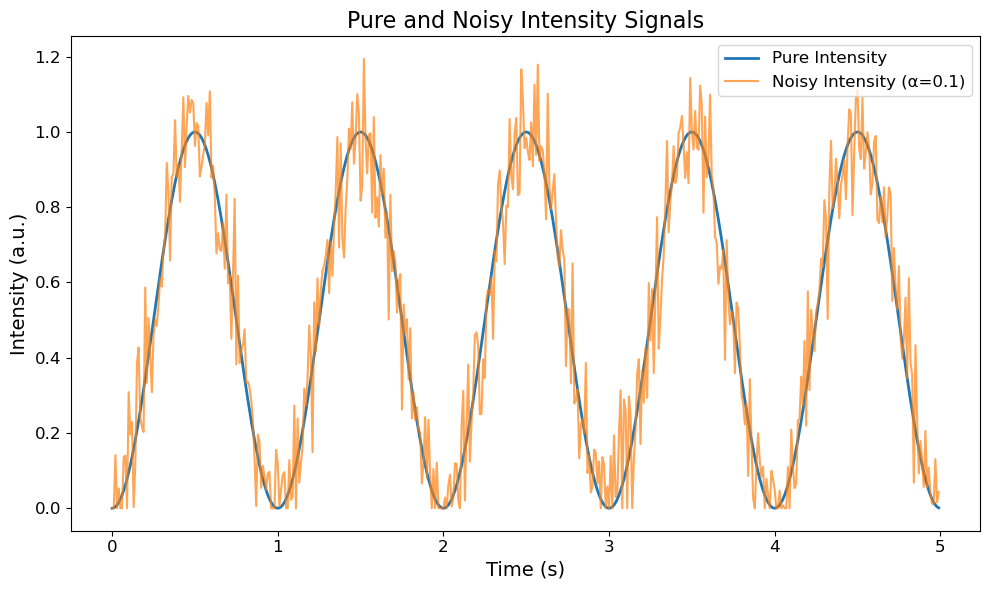

In [130]:
# Step 1: Signal Setup
t = np.arange(0, 5, 0.01)
A = 1.0
f = 0.5
phi = 0
alpha = 0.1

def adjustable_intensity(t, A, f, phi, alpha):
    pure_intensity = A * (np.sin(2 * np.pi * f * t + phi))**2
    noise = alpha * np.random.randn(len(t))
    return np.clip(pure_intensity + noise, 0, None)

I_pure = adjustable_intensity(t, A, f, phi, 0)
I_noisy_raw = adjustable_intensity(t, A, f, phi, alpha)

# Plot: Pure vs Noisy
plt.figure(figsize=(10, 6))
plt.plot(t, I_pure, label="Pure Intensity", linewidth=2)
plt.plot(t, I_noisy_raw, label=f"Noisy Intensity (α={alpha})", alpha=0.7)
plt.title("Pure and Noisy Intensity Signals")
plt.xlabel("Time (s)")
plt.ylabel("Intensity (a.u.)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()



<div style="text-align: justify">
    

## **FFT-Based Visibility Estimation**

This section demonstrates how to estimate signal visibility using the **Fast Fourier Transform (FFT)**. The core idea is to isolate the dominant frequency component from a noisy signal and reconstruct the original periodic structure. The process is illustrated through four subplots:

### **(1) Noisy Intensity Signal**

The first subplot (top-left) shows the time-domain **noisy signal** after adding random Gaussian noise to a sine-squared intensity function. This visualizes the challenge: noise masks the clean periodic structure, making direct visibility measurement unreliable.

### **(2) FFT Magnitude Spectrum**
$$\tilde{I}(f) = \mathcal{F}\{I_{\text{noisy}}(t)\}$$

The second subplot (top-right) displays the **FFT magnitude spectrum**, which represents the signal in the frequency domain. The dominant peak (excluding the DC component) corresponds to the true periodic component of the signal. Identifying this peak allows us to isolate the primary structure from noise.

### **(3) Filtered Signal (Inverse FFT)**
$$I_{\text{filtered}}(t) = \mathcal{F}^{-1}\{\tilde{I}_{\text{filtered}}(f)\}$$

The third subplot (bottom-left) shows the result of an **inverse FFT** after filtering. Only the **DC component** and the **dominant frequency** (and its conjugate) are retained in the spectrum. This produces a smoothed version of the signal that captures the underlying pattern without high-frequency noise.

### **(4) Signal Fitting**

The final subplot (bottom-right) overlays the **original noisy signal** with the **reconstructed signal** from the filtered FFT. The annotated points highlight the peak and valley, used to compute visibility (V).

Through these subplots, we see how FFT can transform a noisy signal into a clearer form by leveraging its spectral properties, enabling reliable visibility computation even under significant noise. This approach offers a fast and intuitive way to estimate visibility from noisy periodic signals by emphasizing frequency-domain filtering and reconstruction.

</div>

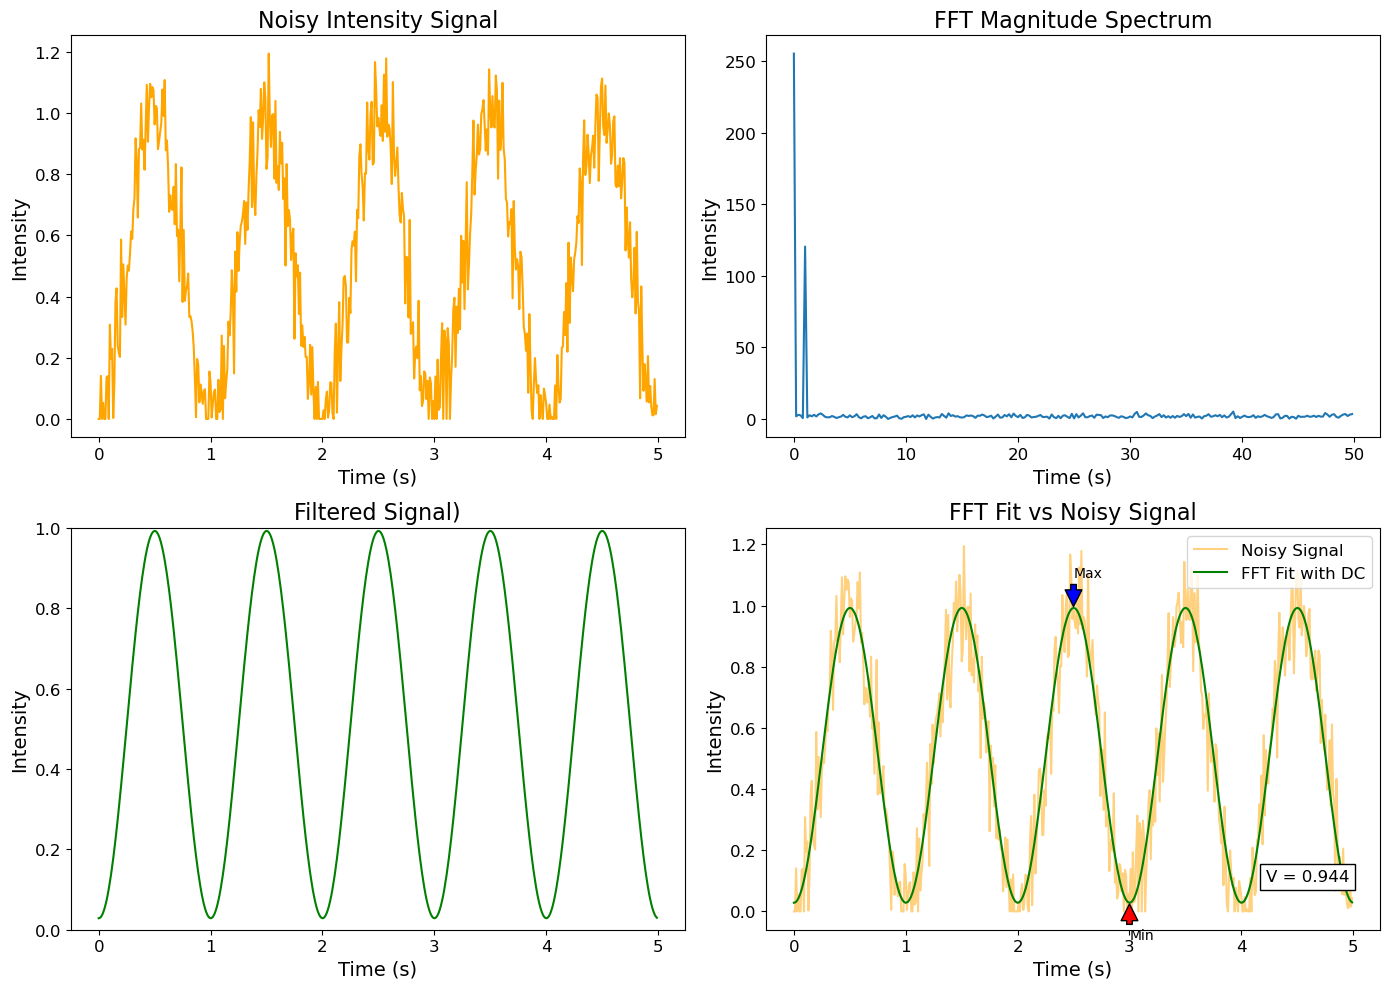

In [131]:
# Normalize
I_noisy = I_noisy_raw / np.max(I_pure)
I_pure_normalized = I_pure / np.max(I_pure)

# FFT and Filtering
N = len(t)
dt = t[1] - t[0]
freqs = fftfreq(N, d=dt)
spectrum = fft(I_noisy)
mag = np.abs(spectrum[:N // 2])
dominant_idx = np.argmax(mag[1:]) + 1

filtered_spectrum = np.zeros_like(spectrum, dtype=complex)
filtered_spectrum[0] = spectrum[0]
filtered_spectrum[dominant_idx] = spectrum[dominant_idx]
filtered_spectrum[-dominant_idx] = np.conj(spectrum[dominant_idx])
I_fft_fit_dc = np.clip(np.real(ifft(filtered_spectrum)), 0, 1)

# FFT-Based Visibility
I_max_dc = np.max(I_fft_fit_dc)
I_min_dc = np.min(I_fft_fit_dc)
visibility_fft_dc = (I_max_dc - I_min_dc) / (I_max_dc + I_min_dc)

# Annotated Peaks
peak_indices, _ = find_peaks(I_fft_fit_dc)
valley_indices, _ = find_peaks(-I_fft_fit_dc)
max_idx = peak_indices[2] if len(peak_indices) >= 3 else np.argmax(I_fft_fit_dc)
min_idx = valley_indices[2] if len(valley_indices) >= 3 else np.argmin(I_fft_fit_dc)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs[0, 0].plot(t, I_noisy, label='Noisy Signal', color='orange')
axs[0, 0].set_title('Noisy Intensity Signal')
axs[0, 1].plot(freqs[:N // 2], mag, label='FFT Magnitude')
axs[0, 1].set_title('FFT Magnitude Spectrum')
axs[1, 0].plot(t, I_fft_fit_dc, label='FFT Fit with DC', color='green')
axs[1, 0].set_title('Filtered Signal)')
axs[1, 0].set_ylim(0, 1)

axs[1, 1].plot(t, I_noisy, label='Noisy Signal', color='orange', alpha=0.5)
axs[1, 1].plot(t, I_fft_fit_dc, label='FFT Fit with DC', color='green')
axs[1, 1].annotate('Max', xy=(t[max_idx], I_fft_fit_dc[max_idx]),
                   xytext=(t[max_idx], I_fft_fit_dc[max_idx] + 0.1),
                   arrowprops=dict(facecolor='blue', shrink=0.05))
axs[1, 1].annotate('Min', xy=(t[min_idx], I_fft_fit_dc[min_idx]),
                   xytext=(t[min_idx], I_fft_fit_dc[min_idx] - 0.12),
                   arrowprops=dict(facecolor='red', shrink=0.05))
axs[1, 1].text(0.95, 0.15, f'V = {visibility_fft_dc:.3f}',
               transform=axs[1, 1].transAxes,
               fontsize=12, ha='right', va='top',
               bbox=dict(facecolor='white', edgecolor='black'))
axs[1, 1].set_title('FFT Fit vs Noisy Signal')
axs[1, 1].legend(loc='upper right')

for ax in axs.flat:
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Intensity')

plt.tight_layout()
plt.show()


<div style="text-align: justify">
    
## Least-Squares Visibility Estimation

This section uses **nonlinear least-squares fitting** to estimate the visibility of a noisy intensity signal by modeling it as a sine-squared function.

Here, we assume the true signal follows a sine-squared intensity profile:

$$
I(t) = A \cdot \sin^2(2\pi f t + \phi) + C
$$

where  $A $ is the amplitude of the modulation, $f $ for the frequency of the signal, $ \phi $ corresponds the phase shift, and $ C $ is the constant offset (baseline).

To improve fitting accuracy, initial parameter guesses are derived from the pure signal. This corresponds to having a user who is **very good at making educated guesses**:

- **Frequency estimate**: from the number of peaks detected in the noiseless signal.
- **Amplitude**: estimated as the range $ \max - \min $.
- **Offset**: estimated as the minimum value of the signal.
- **Phase**: assumed to be zero as a starting point.

These guesses are then passed to the nonlinear curve-fitting function to avoid local minima and improve convergence.

Now, using the `curve_fit()` function from `scipy.optimize`, the model is fitted to the **noisy signal**, minimizing the sum of squared residuals between the model and the data. The result is a smoothed approximation of the original waveform.

</div>

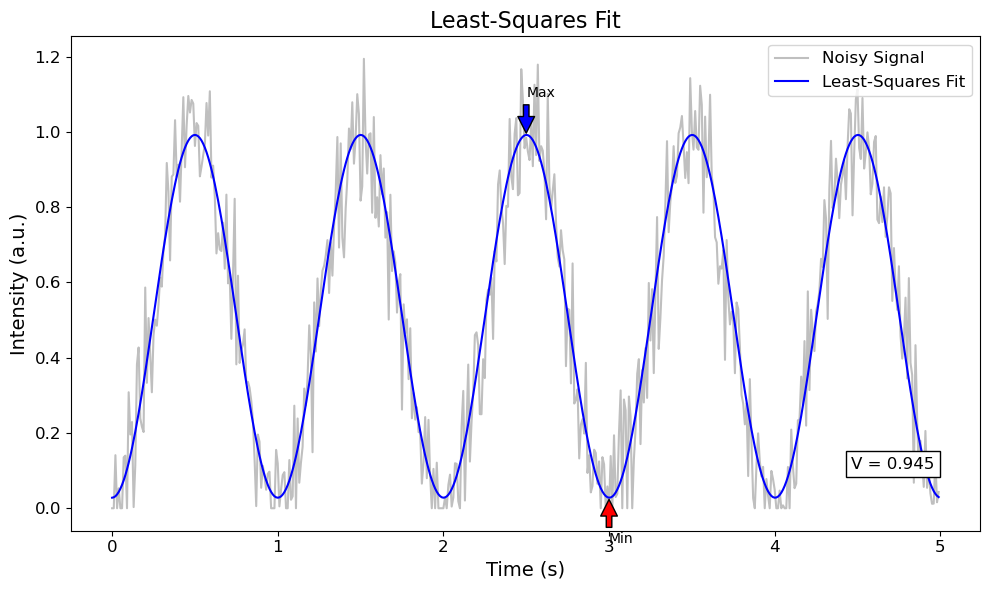

In [132]:
# Define the sine-squared model
def sine_squared_model(t, A, f, phi, C):
    return A * (np.sin(2 * np.pi * f * t + phi))**2 + C

def informed_guesses_from_pure(t, y_pure):
    peaks, _ = find_peaks(y_pure)
    duration = t[-1] - t[0]
    f_guess = (len(peaks) / 2) / duration if duration > 0 else 0.5
    A_guess = np.max(y_pure) - np.min(y_pure)
    C_guess = np.min(y_pure)
    phi_guess = 0
    return A_guess, f_guess, phi_guess, C_guess

# Use the pure signal for informed frequency guess
A0, f0, phi0, C0 = informed_guesses_from_pure(t, I_pure_normalized)
popt_pure_based, _ = curve_fit(sine_squared_model, t, I_noisy, p0=[A0, f0, phi0, C0])
I_fit_pure_based = np.clip(sine_squared_model(t, *popt_pure_based), 0, 1)

# Recompute visibility
visibility_leastsquares_pure = (np.max(I_fit_pure_based) - np.min(I_fit_pure_based)) / \
                               (np.max(I_fit_pure_based) + np.min(I_fit_pure_based))

# Plot the corrected least-squares fit
plt.figure(figsize=(10, 6))
plt.plot(t, I_noisy, label='Noisy Signal', color='gray', alpha=0.5)
plt.plot(t, I_fit_pure_based, label='Least-Squares Fit', color='blue')
plt.title('Least-Squares Fit')
plt.xlabel('Time (s)')
plt.ylabel('Intensity (a.u.)')
plt.annotate('Max', xy=(t[max_idx], I_fit_pure_based[max_idx]),
             xytext=(t[max_idx], I_fit_pure_based[max_idx] + 0.1),
             arrowprops=dict(facecolor='blue', shrink=0.05))
plt.annotate('Min', xy=(t[min_idx], I_fit_pure_based[min_idx]),
             xytext=(t[min_idx], I_fit_pure_based[min_idx] - 0.12),
             arrowprops=dict(facecolor='red', shrink=0.05))
plt.text(0.95, 0.15, f'V = {visibility_leastsquares_pure:.3f}',
         transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(facecolor='white', edgecolor='black'))
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


<div style="text-align: justify">

When comparing the visibility values produced by these two methods, we observe that they are **almost the same**. This strong agreement can be attributed to the following factors:

- **Dominance of a Single Frequency Component**  
  The synthetic signal is intentionally designed to contain a single frequency. Since the FFT method retains this frequency, and the least-squares model fits it directly, both methods are effectively analyzing the same feature of the signal.
  

- **Effective Noise Suppression**  
  Both techniques are capable of suppressing noise:
  - FFT filtering discards higher-frequency noise.
  - Least-squares fitting smooths over the noise by adhering to the expected waveform structure.
    
</div>

<div style="text-align: justify">
   
## Signal Smoothing Techniques

Building upon the previous section where visibility was extracted using FFT and least-squares methods, we now investigate how **pre-processing the noisy signal with smoothing filters** can further improve visibility estimation and reduce error. Smoothing helps suppress high-frequency noise that may distort the visibility calculation.

Here, we implemented and compared three common smoothing techniques:

- **FFT Low-Pass Filter**  
  Retains only the lowest frequencies in the FFT spectrum (controlled by a cutoff ratio), effectively discarding high-frequency noise.

- **Gaussian Convolution**  
  Convolves the signal with a Gaussian kernel to blur out rapid fluctuations. The width of the kernel is controlled by the standard deviation $\( \sigma \)$.

- **Windowed Sinc Filter**  
  A Finite Impulse Response (FIR) filter that combines an ideal low-pass sinc function with a Hamming window to reduce spectral leakage and improve smoothness.

Note that each filter aims to recover the general structure of the original signal while suppressing noise.
    
</div>

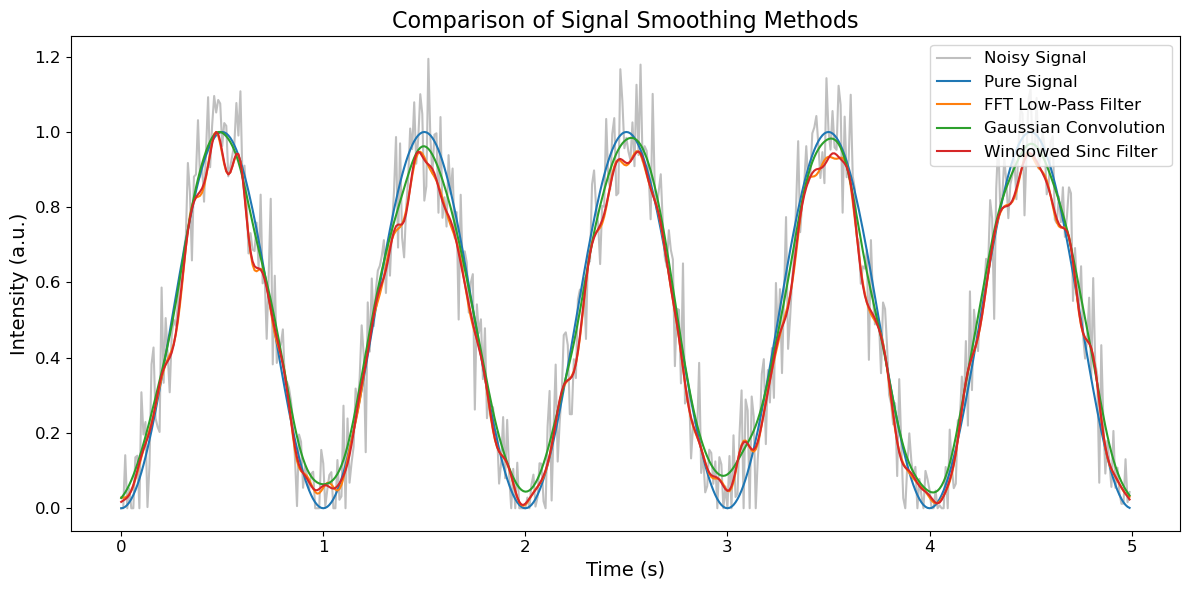

,Method,RMSE
0,FFT Low-Pass,0.055537
1,Gaussian Convolution,0.038273
2,Windowed Sinc,0.054488


In [133]:
# Define smoothing filters
def frequency_filter_smooth(y, cutoff_ratio=0.1):
    N = len(y)
    spectrum = fft(y)
    cutoff = int(cutoff_ratio * N)
    filtered = np.zeros_like(spectrum)
    filtered[:cutoff] = spectrum[:cutoff]
    filtered[-cutoff:] = spectrum[-cutoff:]
    return np.real(ifft(filtered)) / np.max(np.real(ifft(filtered)))

def gaussian_convolve_smooth(y, sigma=5):
    kernel = windows.gaussian(M=51, std=sigma)
    kernel /= np.sum(kernel)
    smoothed = convolve(y, kernel, mode='same')
    return smoothed / np.max(smoothed)

def windowed_sinc_filter(y, fc=0.1, M=51):
    n = np.arange(M)
    sinc = np.sinc(2 * fc * (n - (M - 1) / 2))
    window = windows.hamming(M)
    h = sinc * window
    h /= np.sum(h)
    smoothed = convolve(y, h, mode='same')
    return smoothed / np.max(smoothed)

# Apply smoothing methods
smooth_fft = frequency_filter_smooth(I_noisy)
smooth_gauss = gaussian_convolve_smooth(I_noisy)
smooth_sinc = windowed_sinc_filter(I_noisy)

# Plot all together
plt.figure(figsize=(12, 6))
plt.plot(t, I_noisy, label='Noisy Signal', alpha=0.5, color='gray')
plt.plot(t, I_pure, label='Pure Signal', linewidth=1.5)
plt.plot(t, smooth_fft, label='FFT Low-Pass Filter', linewidth=1.5)
plt.plot(t, smooth_gauss, label='Gaussian Convolution', linewidth=1.5)
plt.plot(t, smooth_sinc, label='Windowed Sinc Filter', linewidth=1.5)
plt.title("Comparison of Signal Smoothing Methods")
plt.xlabel("Time (s)")
plt.ylabel("Intensity (a.u.)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Compute metrics
def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def compute_visibility(y):
    return (np.max(y) - np.min(y)) / (np.max(y) + np.min(y))

methods = ['FFT Low-Pass', 'Gaussian Convolution', 'Windowed Sinc']
signals = [smooth_fft, smooth_gauss, smooth_sinc]

data = {
    "Method": methods,
    "RMSE": [compute_rmse(I_pure_normalized, s) for s in signals]
}

df_comparison = pd.DataFrame(data)
df_comparison


<div style="text-align: justify">
    
The figure above shows the smoothed versions of the noisy signal plotted alongside the original noisy waveform. Each smoothing method—FFT Low-Pass Filter, Gaussian Convolution, and Windowed Sinc Filter—aims to reduce high-frequency noise while preserving the underlying signal structure. To quantitatively assess the performance of these filters, we compute the Root Mean Square Error (RMSE), which measures the average deviation of each smoothed signal from the ideal (pure) reference signal. A lower RMSE value indicates that the filter more accurately recovers the true waveform. Among the three methods, the **Gaussian Convolution produced the lowest RMSE**, suggesting that it achieved the best balance between noise suppression and signal fidelity in this case.

</div>

<div style="text-align: justify">
    
## Comprehensive Analysis of Visibility and Smoothing Performance


Here, we perform a comprehensive parameter sweep to evaluate the performance and robustness of visibility estimation techniques under a variety of signal conditions. Specifically, we vary the amplitude ($A$), frequency ($f$), phase ($\phi$), and noise level ($\alpha$) of the intensity signal to systematically observe how each factor influences the computed visibility. For each parameter value, a corresponding noisy signal is generated. Visibility is then extracted from the noisy signals using the two methods we used earlier.

In parallel, we also apply the three smoothing filters to reduce noise and improve signal fidelity. The quality of these filters is evaluated using the root mean square error (RMSE) relative to the pure signal. By comparing both visibility estimates and RMSE values across all parameter variations, we gain insight into which method or filter is more resilient under different types of distortion.
    
</div>

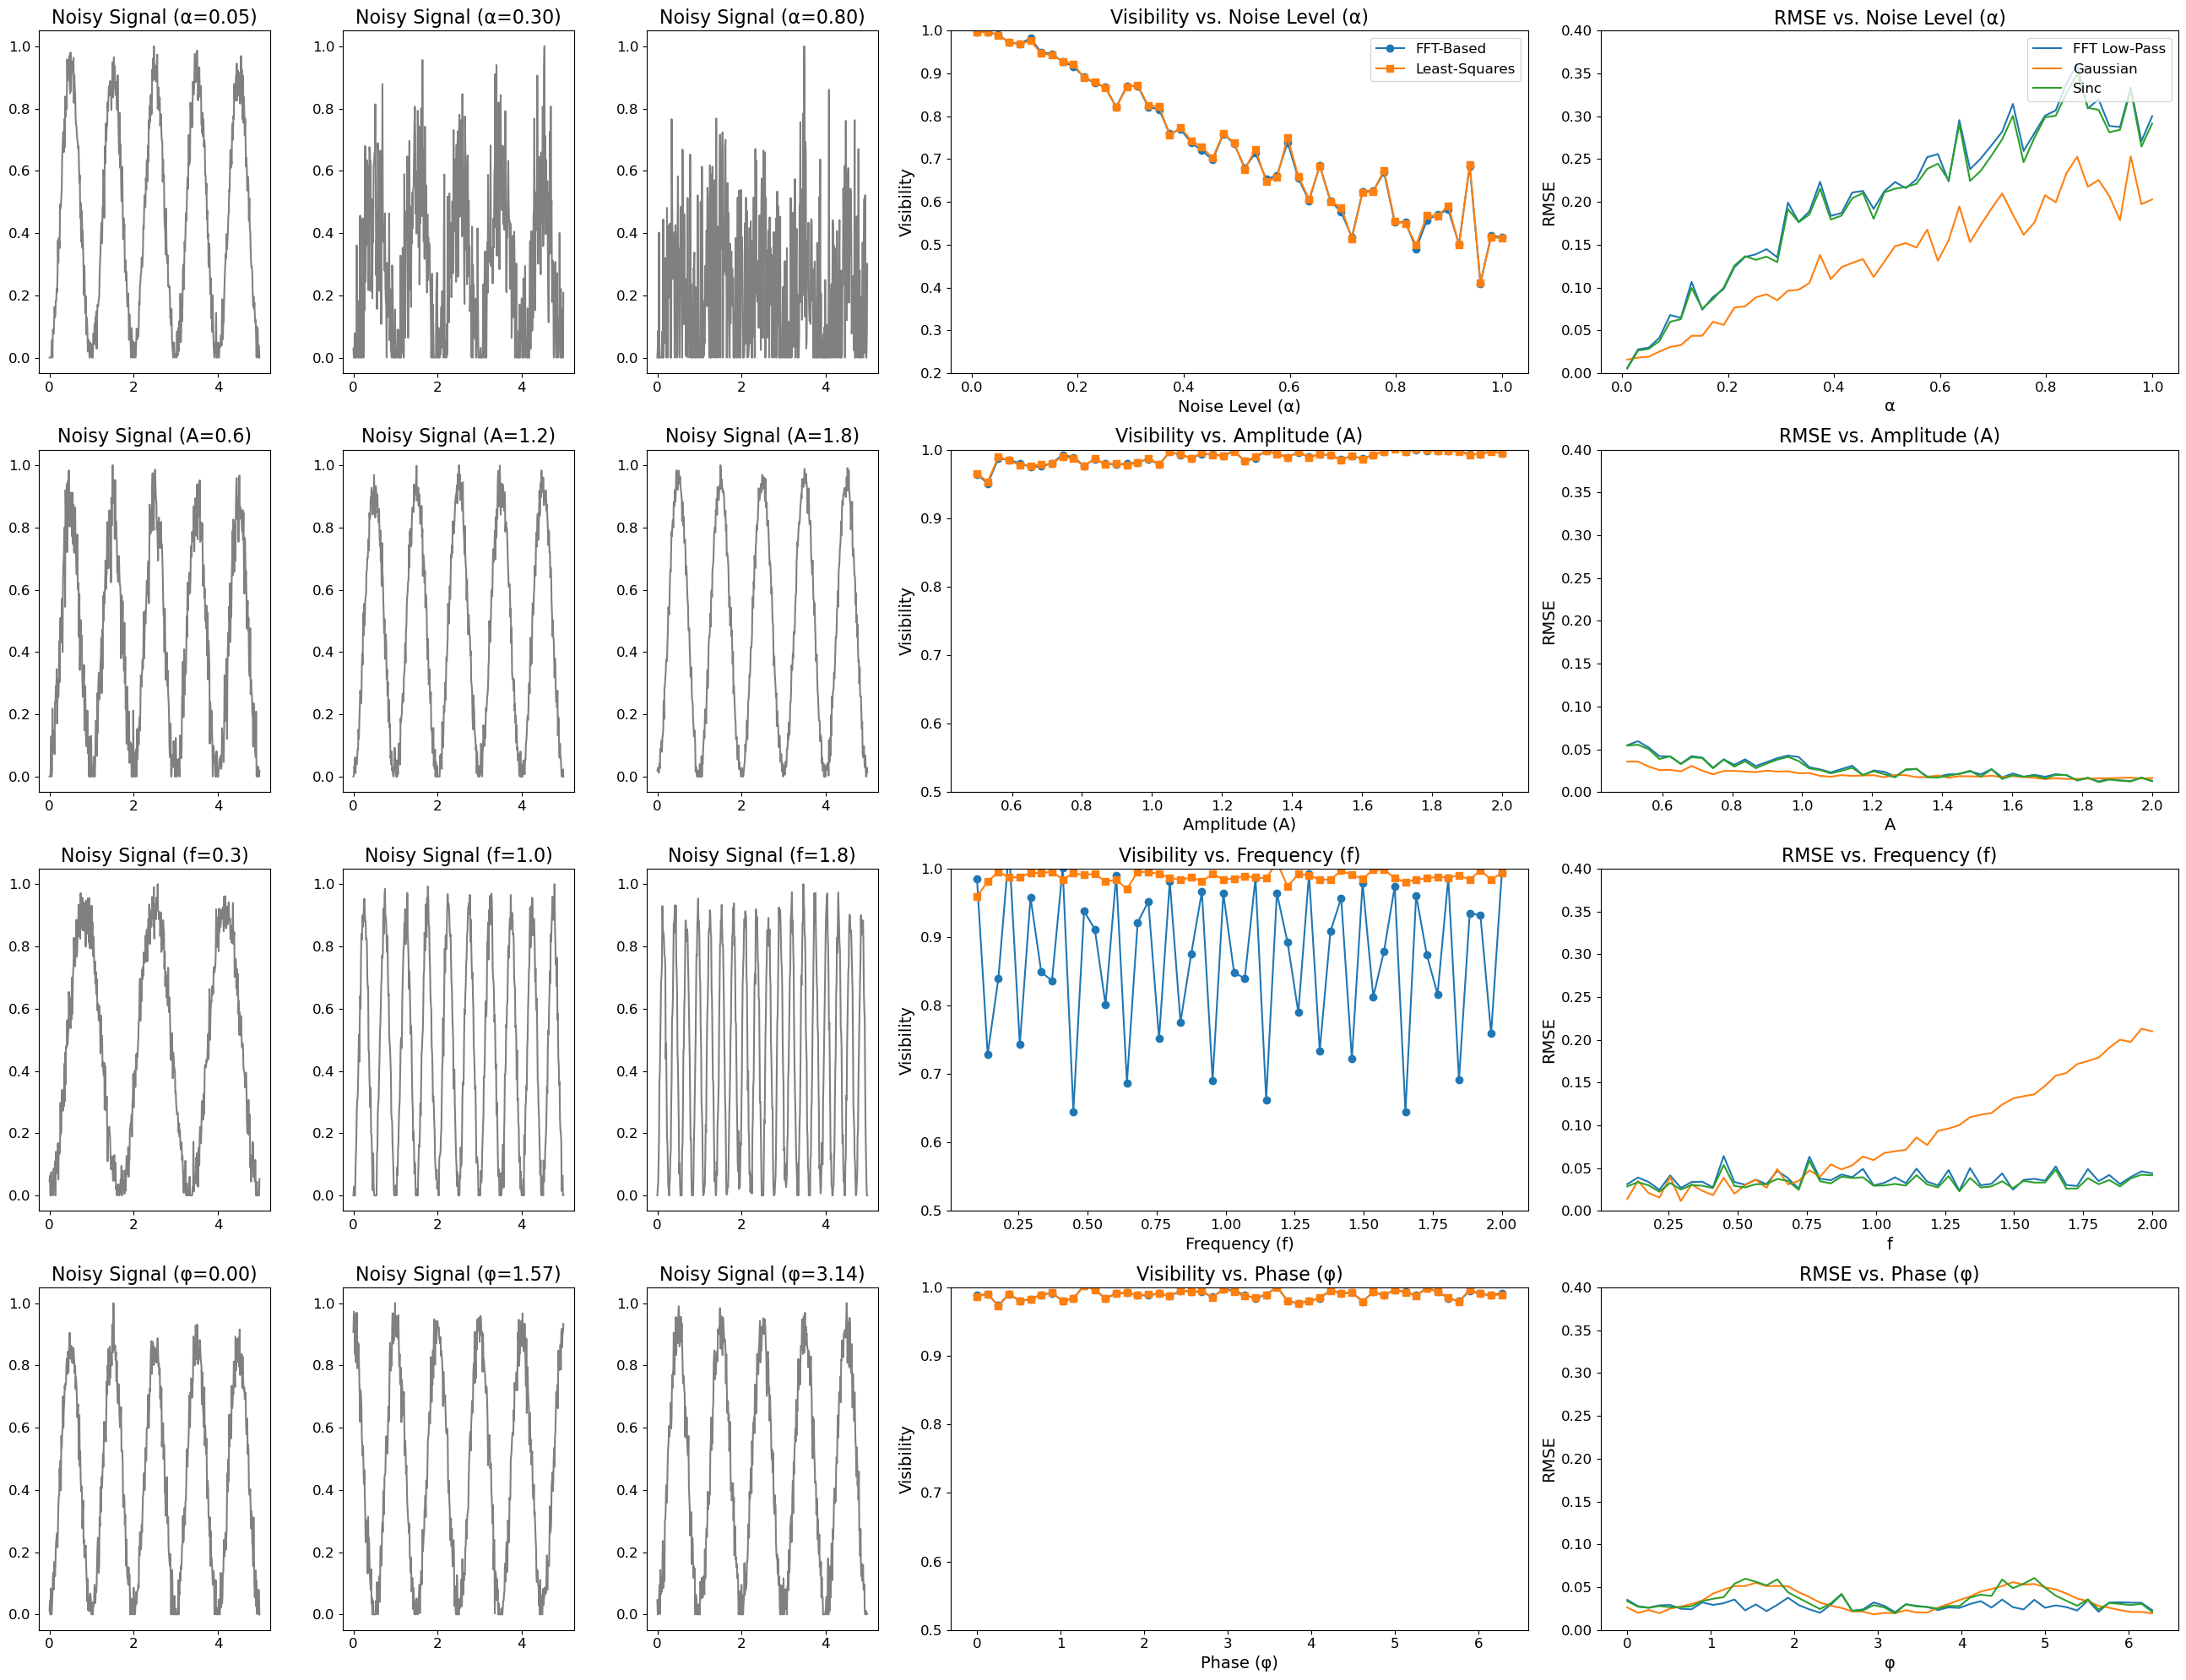

In [134]:
# Time and parameters
t = np.arange(0, 5, 0.01)
A_fixed, f_fixed, phi_fixed, alpha_fixed = 1.0, 0.5, 0.0, 0.05
alpha_vals = np.linspace(0.01, 1, 50)
amplitude_vals = np.linspace(0.5, 2.0, 50)
frequency_vals = np.linspace(0.1, 2.0, 50)
phase_vals = np.linspace(0, 2 * np.pi, 50)
sample_alphas = [0.05, 0.3, 0.8]
sample_amps = [0.6, 1.2, 1.8]
sample_freqs = [0.3, 1.0, 1.8]
sample_phases = [0, np.pi/2, np.pi]


def least_squares_visibility(t, y, f_guess):
    A0, C0, phi0 = np.max(y) - np.min(y), np.min(y), 0
    popt, _ = curve_fit(sine_squared_model, t, y, p0=[A0, f_guess, phi0, C0])
    y_fit = sine_squared_model(t, *popt)
    return (np.max(y_fit) - np.min(y_fit)) / (np.max(y_fit) + np.min(y_fit))

def fft_visibility(t, y):
    N = len(t)
    freqs = fftfreq(N, d=(t[1] - t[0]))
    spectrum = fft(y)
    mag = np.abs(spectrum[:N // 2])
    dominant_idx = np.argmax(mag[1:]) + 1
    filtered = np.zeros_like(spectrum, dtype=complex)
    filtered[0] = spectrum[0]
    filtered[dominant_idx] = spectrum[dominant_idx]
    filtered[-dominant_idx] = np.conj(spectrum[dominant_idx])
    y_fit = np.real(ifft(filtered))
    return (np.max(y_fit) - np.min(y_fit)) / (np.max(y_fit) + np.min(y_fit))

def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def frequency_filter_smooth(y, cutoff_ratio=0.1):
    N, spectrum = len(y), fft(y)
    cutoff = int(cutoff_ratio * N)
    filtered = np.zeros_like(spectrum)
    filtered[:cutoff], filtered[-cutoff:] = spectrum[:cutoff], spectrum[-cutoff:]
    return np.real(ifft(filtered)) / np.max(np.real(ifft(filtered)))

def gaussian_convolve_smooth(y, sigma=5):
    kernel = windows.gaussian(M=51, std=sigma)
    kernel /= np.sum(kernel)
    return convolve(y, kernel, mode='same') / np.max(convolve(y, kernel, mode='same'))

def windowed_sinc_filter(y, fc=0.1, M=51):
    n = np.arange(M)
    sinc = np.sinc(2 * fc * (n - (M - 1) / 2))
    h = sinc * windows.hamming(M)
    h /= np.sum(h)
    return convolve(y, h, mode='same') / np.max(convolve(y, h, mode='same'))

# Smoothers
smoothers = [frequency_filter_smooth, gaussian_convolve_smooth, windowed_sinc_filter]
smoother_labels = ['FFT Low-Pass', 'Gaussian', 'Sinc']

# Storage
vis_fft_alpha, vis_ls_alpha, rmse_alpha_all = [], [], [[] for _ in smoothers]
vis_fft_amp, vis_ls_amp, rmse_amp_all = [], [], [[] for _ in smoothers]
vis_fft_freq, vis_ls_freq, rmse_freq_all = [], [], [[] for _ in smoothers]
vis_fft_phi, vis_ls_phi, rmse_phi_all = [], [], [[] for _ in smoothers]

# Parameter sweeps
for i, vals, get_param, vis_fft, vis_ls, rmse_all in zip(
    range(4),
    [alpha_vals, amplitude_vals, frequency_vals, phase_vals],
    [lambda a: (A_fixed, f_fixed, phi_fixed, a),
     lambda A: (A, f_fixed, phi_fixed, alpha_fixed),
     lambda f: (A_fixed, f, phi_fixed, alpha_fixed),
     lambda phi: (A_fixed, f_fixed, phi, alpha_fixed)],
    [vis_fft_alpha, vis_fft_amp, vis_fft_freq, vis_fft_phi],
    [vis_ls_alpha, vis_ls_amp, vis_ls_freq, vis_ls_phi],
    [rmse_alpha_all, rmse_amp_all, rmse_freq_all, rmse_phi_all]):

    for v in vals:
        A, f, phi, alpha = get_param(v)
        I_pure = adjustable_intensity(t, A, f, phi, 0)
        I_noisy = adjustable_intensity(t, A, f, phi, alpha)
        I_pure /= np.max(I_pure); I_noisy /= np.max(I_pure)
        duration = t[-1] - t[0]
        peaks, _ = find_peaks(I_pure)
        f_guess = (len(peaks) / 2) / duration if duration > 0 else f
        vis_fft.append(fft_visibility(t, I_noisy))
        vis_ls.append(least_squares_visibility(t, I_noisy, f_guess))
        for s, smoother in enumerate(smoothers):
            rmse_all[s].append(compute_rmse(I_pure, smoother(I_noisy)))

# Plotting
fig, axs = plt.subplots(4, 5, figsize=(26, 20), gridspec_kw={'width_ratios': [.6, .6, .6, 1.5, 1.5]})

def plot_rmse(ax, x_vals, rmse_lists, labels, title, xlabel, show_legend=False):
    for rmse, label in zip(rmse_lists, labels):
        ax.plot(x_vals, rmse, label=label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("RMSE")
    ax.set_ylim(0, 0.4)
    if show_legend:
        ax.legend(loc='upper right', fontsize=12)

# Visibility + RMSE trends
axs[0, 3].plot(alpha_vals, vis_fft_alpha, label='FFT-Based', marker='o')
axs[0, 3].plot(alpha_vals, vis_ls_alpha, label='Least-Squares', marker='s')
axs[0, 3].set_title('Visibility vs. Noise Level (α)')
axs[0, 3].set_xlabel("Noise Level (α)")
axs[0, 3].set_ylabel("Visibility")
axs[0, 3].legend(loc='upper right')
axs[0, 3].set_ylim(0.2, 1)
plot_rmse(axs[0, 4], alpha_vals, rmse_alpha_all, smoother_labels, "RMSE vs. Noise Level (α)", "α", show_legend=True)

axs[1, 3].plot(amplitude_vals, vis_fft_amp, label='FFT-Based', marker='o')
axs[1, 3].plot(amplitude_vals, vis_ls_amp, label='Least-Squares', marker='s')
axs[1, 3].set_title('Visibility vs. Amplitude (A)')
axs[1, 3].set_xlabel("Amplitude (A)")
axs[1, 3].set_ylabel("Visibility")
axs[1, 3].set_ylim(0.5, 1)
plot_rmse(axs[1, 4], amplitude_vals, rmse_amp_all, smoother_labels, "RMSE vs. Amplitude (A)", "A", show_legend=False)

axs[2, 3].plot(frequency_vals, vis_fft_freq, label='FFT-Based', marker='o')
axs[2, 3].plot(frequency_vals, vis_ls_freq, label='Least-Squares', marker='s')
axs[2, 3].set_title('Visibility vs. Frequency (f)')
axs[2, 3].set_xlabel("Frequency (f)")
axs[2, 3].set_ylabel("Visibility")
axs[2, 3].set_ylim(0.5, 1)
plot_rmse(axs[2, 4], frequency_vals, rmse_freq_all, smoother_labels, "RMSE vs. Frequency (f)", "f", show_legend=False)

axs[3, 3].plot(phase_vals, vis_fft_phi, label='FFT-Based', marker='o')
axs[3, 3].plot(phase_vals, vis_ls_phi, label='Least-Squares', marker='s')
axs[3, 3].set_title('Visibility vs. Phase (φ)')
axs[3, 3].set_xlabel("Phase (φ)")
axs[3, 3].set_ylabel("Visibility")
axs[3, 3].set_ylim(0.5, 1)
plot_rmse(axs[3, 4], phase_vals, rmse_phi_all, smoother_labels, "RMSE vs. Phase (φ)", "φ", show_legend=False)

# Representative signal snapshots
for j, alpha in enumerate(sample_alphas):
    I_noisy = adjustable_intensity(t, A_fixed, f_fixed, phi_fixed, alpha)
    I_noisy /= np.max(I_noisy)
    axs[0, j].plot(t, I_noisy, color='gray')
    axs[0, j].set_title(f'Noisy Signal (α={alpha:.2f})')

for j, A in enumerate(sample_amps):
    I_noisy = adjustable_intensity(t, A, f_fixed, phi_fixed, alpha_fixed)
    I_noisy /= np.max(I_noisy)
    axs[1, j].plot(t, I_noisy, color='gray')
    axs[1, j].set_title(f'Noisy Signal (A={A:.1f})')

for j, f in enumerate(sample_freqs):
    I_noisy = adjustable_intensity(t, A_fixed, f, phi_fixed, alpha_fixed)
    I_noisy /= np.max(I_noisy)
    axs[2, j].plot(t, I_noisy, color='gray')
    axs[2, j].set_title(f'Noisy Signal (f={f:.1f})')

for j, phi in enumerate(sample_phases):
    I_noisy = adjustable_intensity(t, A_fixed, f_fixed, phi, alpha_fixed)
    I_noisy /= np.max(I_noisy)
    axs[3, j].plot(t, I_noisy, color='gray')
    axs[3, j].set_title(f'Noisy Signal (φ={phi:.2f})')

plt.tight_layout()
plt.show()

Shown in the first three columns are representative noisy signals under varying parameters. These snapshots provide a visual sense of how the signal degrades or shifts as each parameter changes. The fourth column presents visibility trends, comparing the performance of the FFT-based and least-squares methods across the respective parameter sweeps. Finally, the fifth column displays RMSE plots, quantifying how accurately each smoothening methods reconstructs the clean signal.

Based on the comprehensive parameter sweep and visualization results, we can draw several important conclusions regarding the robustness of the two visibility estimation methods and the performance of the applied smoothing filters.

### FFT vs Least Squares Fitting Methods 

The **least-squares fitting method consistently demonstrates superior resilience across varying signal conditions**. Whether the signal’s amplitude, frequency, phase, or noise level is altered, the least-squares approach maintains stable and accurate visibility estimates. This robustness stems from its model-based nature—it directly fits a sine-squared function to the data, allowing it to effectively capture the underlying periodic structure even when the signal is moderately distorted by noise.

In contrast, the **FFT-based method is more susceptible to degradation**, especially at higher noise levels or when the signal frequency does not align neatly with discrete FFT bins. Because it relies on identifying a dominant frequency peak in the spectrum, it can misinterpret spectral components when noise masks or distorts the true frequency content. This issue is particularly evident across the frequency sweep, where the visibility trend from the FFT method appears jagged or unstable—a manifestation of **spectral leakage**, where energy spreads across multiple bins due to mismatch between the signal frequency and the FFT resolution. As a result, the FFT-derived visibility may fluctuate or become underestimated under challenging conditions, unlike the smoother and more accurate output of the least-squares approach.


### Smoothing Filters 

In terms of signal smoothing, the **Gaussian convolution filter** emerges as the most effective among the three evaluated techniques. It consistently achieves the **lowest Root Mean Square Error (RMSE)** across all parameter sweeps—noise level, amplitude, frequency, and phase—demonstrating its strong capacity to suppress noise while preserving the underlying periodic structure of the signal. This performance is attributed to the Gaussian filter's localized and smooth weighting, which effectively reduces random fluctuations without overly distorting the waveform’s peaks and troughs.

The **FFT low-pass filter**, while straightforward to implement, tends to **blur finer signal details** and may introduce **ringing artifacts**, especially when the cutoff frequency is not optimally chosen. This results in less accurate reconstructions, particularly when the signal contains sharp transitions or when its frequency content shifts.

The **windowed sinc filter** offers a good compromise by balancing frequency selectivity and time localization. However, it performs **slightly less effective** than Gaussian convolution in preserving signal fidelity, as evidenced by its slightly higher RMSE in most scenarios. This is likely due to its fixed kernel design, which may not adapt as well to local signal variations compared to the Gaussian’s smoother attenuation profile.

Overall, for denoising periodic signals while maintaining high structural accuracy, **Gaussian convolution proves to be the most reliable smoothing technique** among those tested in this project.


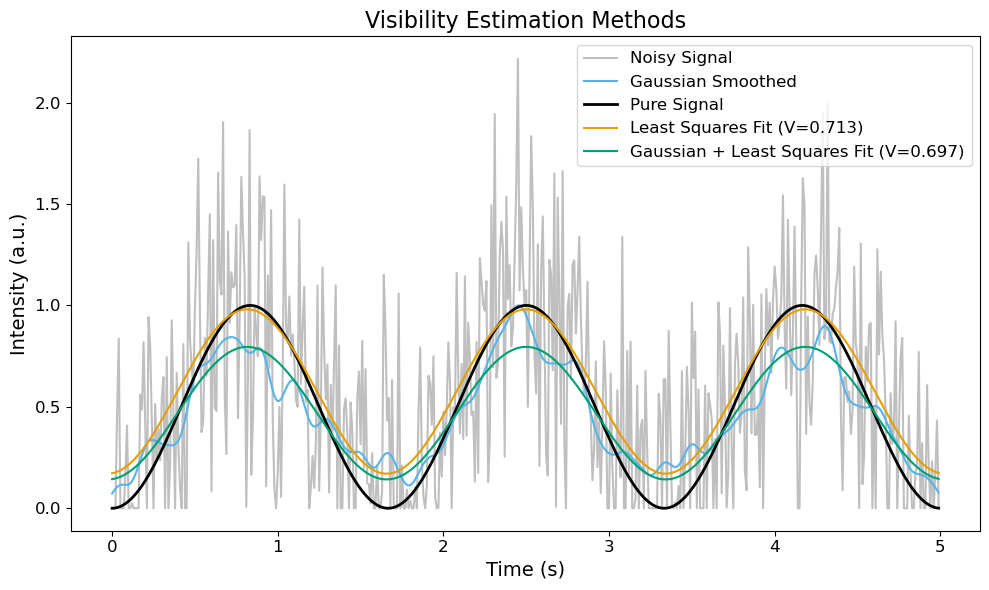

In [135]:
A, f, phi, alpha = 1.0, 0.3, 0, 0.5

I_pure = adjustable_intensity(t, A, f, phi, 0)
I_noisy = adjustable_intensity(t, A, f, phi, alpha)
I_pure /= np.max(I_pure); I_noisy /= np.max(I_pure)

A0, f0, phi0, C0 = informed_guesses_from_pure(t, I_pure)

popt_raw, _ = curve_fit(sine_squared_model, t, I_noisy, p0=[A0, f0, phi0, C0])
I_fit_raw = sine_squared_model(t, *popt_raw)

I_smooth_gauss = gaussian_convolve_smooth(I_noisy, sigma=5)
popt_smoothed, _ = curve_fit(sine_squared_model, t, I_smooth_gauss, p0=[A0, f0, phi0, C0])
I_fit_smoothed = sine_squared_model(t, *popt_smoothed)

v_smooth = compute_visibility(I_fit_smoothed)
v_gauss = compute_visibility(I_smooth_gauss)

plt.figure(figsize=(10, 6))
plt.plot(t, I_noisy, label='Noisy Signal', color='gray', alpha=0.5)
plt.plot(t, I_smooth_gauss, label=f'Gaussian Smoothed', color='#56B4E9')  # sky blue
plt.plot(t, I_pure, label=f'Pure Signal', color='black', linewidth=2)
plt.plot(t, I_fit_raw, label=f'Least Squares Fit (V={v_raw:.3f})', color='#E69F00')         # orange
plt.plot(t, I_fit_smoothed, label=f'Gaussian + Least Squares Fit (V={v_smooth:.3f})', color='#009E73')    # bluish green
plt.title('Visibility Estimation Methods')
plt.xlabel('Time (s)')
plt.ylabel('Intensity (a.u.)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Given the insights mentioned above, the recommended strategy for optimal visibility extraction is to first apply **Gaussian convolution smoothing to the noisy signal, followed by least-squares curve fitting**, as seen in the figure above. This combination offers the best balance between noise reduction and accurate recovery of signal features, resulting in reliable visibility estimates across a wide range of experimental conditions.

## Conclusion

<br>

<div style="text-align: justify;"> 
This project provided a comprehensive comparison between FFT-based reconstruction and nonlinear least-squares curve fitting for estimating the visibility of noisy periodic signals—an essential task in experimental physics and optical measurements. Both methods were evaluated for their accuracy, robustness, and ability to handle varying signal parameters such as amplitude, frequency, phase, and noise level. The least-squares fitting method proved to be more robust across a wide range of conditions. Its model-based approach consistently produced smoother and more reliable visibility estimates, even under high noise levels or when the signal frequency did not align well with discrete Fourier bins. In contrast, the FFT-based method, while faster and intuitive, was more vulnerable to spectral leakage and noise interference, especially when the signal conditions deviated from ideal periodicity. To enhance signal quality before applying these estimation methods, three smoothing filters were tested: FFT low-pass filtering, Gaussian convolution, and windowed sinc filtering. Among these, Gaussian convolution emerged as the most effective, consistently achieving the lowest RMSE and best preserving signal structure across all tested conditions. Overall, the recommended strategy for optimal visibility estimation is a two-step approach: apply Gaussian smoothing followed by least-squares curve fitting. This combination ensures reliable visibility computation, even in noisy and complex signal environments. 
</div>